# Baseline Model: BOW, Linear Regression

## Load Data

In [1]:
import pandas as pd

In [2]:
gb = pd.read_csv('GB_youtube_trending_data.csv')
print('GB dataset shape: ' + str(gb.shape))

us = pd.read_csv('US_youtube_trending_data.csv')
print('US dataset shape: ' + str(us.shape))

df = pd.concat([gb,us])
print('total dataset shape: ' + str(df.shape))

GB dataset shape: (93395, 16)
US dataset shape: (93391, 16)
total dataset shape: (186786, 16)


In [3]:
df.sample(3)

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
51637,AuXmuhmtwz4,How Difficult is it to Ride a Penny Farthing?,2021-04-30T10:25:27Z,UCIRiWCPZoUyZDbydIqitHtQ,Mike Boyd,24,2021-05-01T00:00:00Z,penny|farthing|bike|weird vehicles|mike|boyd|l...,306464,23125,142,1623,https://i.ytimg.com/vi/AuXmuhmtwz4/default.jpg,False,False,Get CuriosityStream AND Nebula for less than $...
43099,cU6cnHHX4LM,펜타곤(PENTAGON) - 'DO or NOT' Official Music Video,2021-03-15T09:00:09Z,UCw4NcAAtRsjL-cGlBrUnMTQ,PENTAGON 펜타곤 (Official YouTube Channel),10,2021-03-19T00:00:00Z,kpop|PENTAGON|펜타곤|진호|후이|홍석|신원|여원|옌안|유토|키노|우석|J...,6064651,232104,7511,44724,https://i.ytimg.com/vi/cU6cnHHX4LM/default.jpg,False,False,펜타곤(PENTAGON) - 'DO or NOT' Official Music Vid...
55413,Z189RXBXfGg,The NBA Arrives In Fortnite,2021-05-19T14:31:09Z,UClG8odDC8TS6Zpqk9CGVQiQ,Fortnite,20,2021-05-20T00:00:00Z,yt:cc=on|fortnite|fortnite nba|nba|the crossov...,873975,47069,1072,5681,https://i.ytimg.com/vi/Z189RXBXfGg/default.jpg,False,False,Lace up... The Crossover is going to knock you...


## Create BOW Embedding

In [4]:
# We need all the titles in our dataset

titles = df['title']
titles

0        I left youtube for a month and THIS is what ha...
1             TAXI CAB SLAYER KILLS 'TO KNOW HOW IT FEELS'
2        Apex Legends | Stories from the Outlands – “Th...
3                           Nines - Clout (Official Video)
4                       i don't know what im doing anymore
                               ...                        
93386     Hermitcraft 8 | Ep.9: ANTI BOATEM DEFENCE FORCE!
93387    The AFTERMATH of listing all 40 cars for sale ...
93388      When a kid thinks he’s to smart for his grade :
93389          Minecraft Manhunt, But Trash Gives OP Items
93390                      Volcano of the Dead! - DayZ Mod
Name: title, Length: 186786, dtype: object

In [5]:
# Now we can use CountVectorizer to build our embeddings
from sklearn.feature_extraction.text import CountVectorizer

# Since this is our baseline model, we will use the default perameters for the vectorizer
# This means that there will be very limited pre-processing to the tokens, simply just lowercase
embedder = CountVectorizer()
embedder.fit(titles)
embedder

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [6]:
# Let's test the embedder
sample_title = titles.sample()
sample_title

sample_title, embedder.transform(sample_title).toarray()

(37465    CHAOS AGENT SKIN IS BACK IN FORTNITE!
 Name: title, dtype: object, array([[0, 0, 0, ..., 0, 0, 0]], dtype=int64))

In [7]:
# Let's make it into a function so we can use it on a dataframe later

def embed(text):
    return embedder.transform([text]).toarray()

## Creating the Dataset

In [8]:
# We want to predict the view count with our embedded vector,
# so we are going to need both our embeddings and the correspoding
# view counts

embeddings = embedder.transform(df['title'])
views = df['view_count'].to_numpy()

embeddings.shape, views.shape

((186786, 21290), (186786,))

## Linear Regression Model

In [9]:
# For the baseline model, let's use the default perameters

from sklearn.linear_model import LinearRegression

lr = LinearRegression()

In [10]:
# Let's use cross validation to see how it performs

from sklearn.model_selection import cross_validate

cv_results = cross_validate(lr, embeddings, views, cv=10, n_jobs=10, scoring=['neg_mean_squared_error', 'r2'])
cv_results

{'fit_time': array([114.62855554, 112.26919603,  88.20360994, 105.9631753 ,
        121.70671296, 115.17542791, 118.67543674, 104.6194272 ,
         90.04736018, 105.69755459]),
 'score_time': array([0.        , 0.        , 0.01563025, 0.        , 0.        ,
        0.        , 0.01563001, 0.        , 0.        , 0.        ]),
 'test_neg_mean_squared_error': array([-5.44779079e+13, -4.85260855e+13, -4.53427376e+13, -8.52897952e+13,
        -4.70751785e+13, -6.57873941e+13, -4.54969001e+13, -4.50817466e+13,
        -8.17742714e+13, -5.53059799e+13]),
 'test_r2': array([-0.52038537, -1.68848746, -0.36493162, -0.10816334, -0.39682136,
        -0.21117885, -0.47231531, -0.22454227,  0.21555149, -0.2086462 ])}

In [12]:
# Let's get the average MSE as well as R2 score

results = {}
results['MSE'] = sum(cv_results['test_neg_mean_squared_error']) / 10
results['R2'] = sum(cv_results['test_r2']) / 10

results

{'MSE': -57415799682205.35, 'R2': -0.3979920290811073}

In [13]:
# Looks like the model performs very poorly.
# A negative r^2 value means that the model performs worse than a horizontal line.
# This makes sense as it is using the most basic form of embedding,
# along with the most basic model.

# It is also very likely that the data is simply non linear, thus a linear model
# is bound to perform poorly

## Visualizations

In [16]:
# Let's take a look at how the data is distributed.
# Generally, because of their sparse nature, BOW embeddings are highly compressable
# We can use SVD to compress our embeddings for visualization

# Since we are working with Sparse Matrix we can use TruncatedSVD
from sklearn.decomposition import TruncatedSVD

svd_embeddings = TruncatedSVD(n_components=2).fit_transform(embeddings)
svd_embeddings

array([[ 0.26449606, -0.02101968],
       [ 0.25285891, -0.00596183],
       [ 1.82301177, -0.42374467],
       ...,
       [ 0.28342311, -0.02082473],
       [ 0.05542347, -0.01059827],
       [ 1.06479866, -0.22592808]])

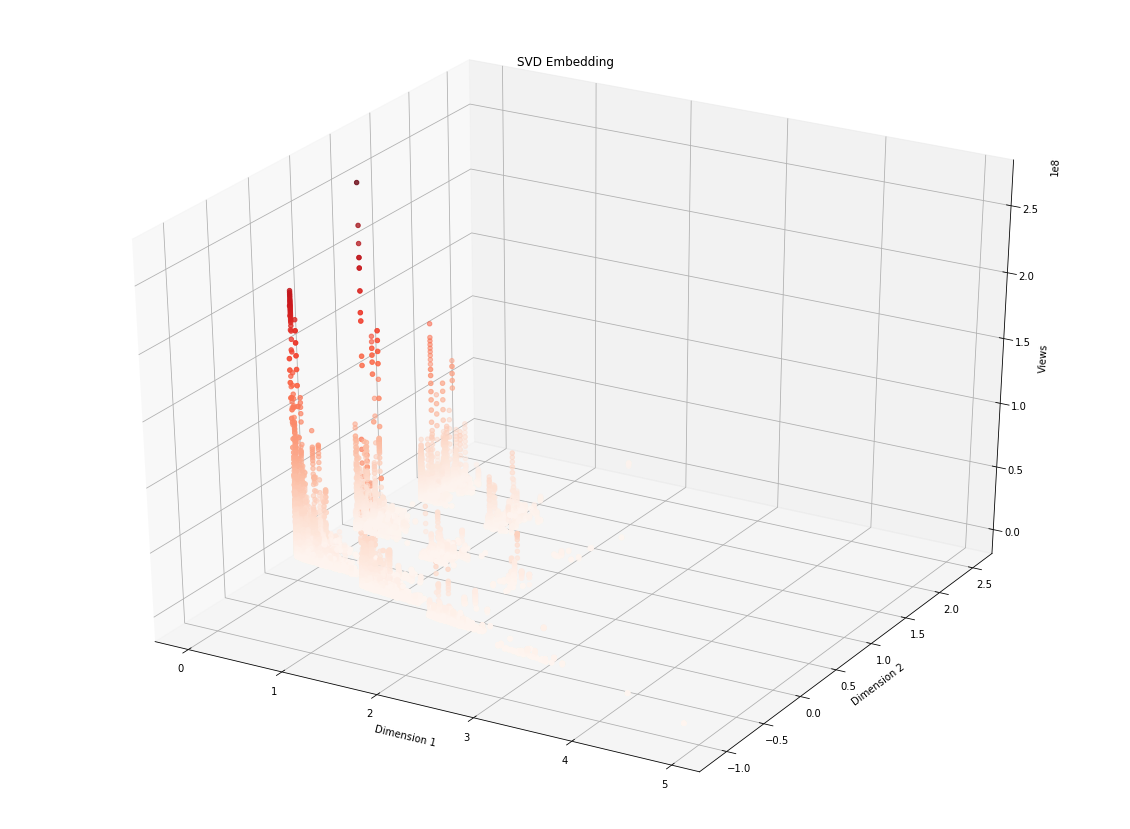

In [22]:
# Now let's make a graph where the x and y axis are our embeddings,
# and the z axis is the view count.

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

fig = plt.figure(figsize=(20,15))
ax = plt.axes(projection='3d')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Views')
ax.set_title('SVD Embedding')
ax.scatter3D(svd_embeddings[:,0], svd_embeddings[:,1], views, c=views, cmap='Reds')

In [ ]:
# As seen here, the data is not very linearly seperable, there are many peaks and valleys
# We will consider this in our future models